I've broken down each question into it's own section with corresponding header and tried to explain my thought process as I worked through each section. I look forward to discussing this case study.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dh_transaction = pd.read_csv('dunnhumby - Carbo-Loading CSV/dh_transactions.csv')
dh_store_lookup = pd.read_csv('dunnhumby - Carbo-Loading CSV/dh_store_lookup.csv')
dh_product = pd.read_csv('dunnhumby - Carbo-Loading CSV/dh_product_lookup.csv')
dh_causal = pd.read_csv('dunnhumby - Carbo-Loading CSV/dh_causal_lookup.csv')

### What are the top 5 products in each commodity?

I'm assuming that top 5 products refers to the 5 products within each category that have the most units sold

In [3]:
# join the transaction and product lookup dataframes to get product descriptions matched up with sales
df = dh_transaction.merge(dh_product, on='upc')
# grab only relevant columns
df2 = df[['commodity','units','upc','product_description']]
# group by commodity class and UPC to find total units sold, then sort in descending order
df3 = df2.groupby(['commodity', 'upc']).sum().sort_values(['commodity','units'], ascending=False)
df3.sample(10)

,,units
commodity,upc,
syrups,9999971884,9956
pasta sauce,5100013828,126
pasta,3687101163,9
pasta sauce,2700042240,37247
pasta,3340061152,344
pasta sauce,5100015055,8494
syrups,7468300312,506
pasta,7914730189,10
pasta sauce,8532801989,384


In [4]:
'''create a dataframe that has two columns, the upc and total units sold, for the 5 highest selling items in each 
    commodity category'''
final = pd.DataFrame()
for name in df.commodity.unique():
    final = pd.concat([final, df3.loc[name].head()])
final.reset_index(inplace=True)

# merge the total units dataframe with the product df to get the descriptions and brand for each product
top_5 = final.merge(dh_product, on='upc')

In [5]:
for name in top_5.commodity.unique():
    print('                     ',name.upper())
    print('------------------------------------------------------')
    print(top_5[['product_description','brand']][top_5.commodity==name])
    print('------------------------------------------------------')

                      PASTA
------------------------------------------------------
               product_description          brand
0     PRIVATE LABEL THIN SPAGHETTI  Private Label
1  PRIVATE LABEL SPAGHETTI REGULAR  Private Label
2   PRIVATE LABEL ANGEL HAIR PASTA  Private Label
3      PRIVATE LABEL ELBO MACARONI  Private Label
4     PRIVATE LABEL THIN SPAGHETTI  Private Label
------------------------------------------------------
                      PASTA SAUCE
------------------------------------------------------
         product_description   brand
5     RAGU TRADITIONAL PLAIN    Ragu
6  PREGO REG SPAGHETTI SAUCE   Prego
7   RAGU OWS SPAG SAUCE MEAT    Ragu
8     HUNT TRADITIONAL SAUCE  Hunt's
9   RAGU\CHZ CREATION ALFRDO    Ragu
------------------------------------------------------
                      PANCAKE MIXES
------------------------------------------------------
                   product_description          brand
10           AJ BUTTERMILK PANCAKE MIX    Aunt Jemi

I'm assuming the brand 'Private Label' refers to the in house brand of the grocery store. At least one product by this brand appears in every category except Pasta Sauce. From experience a store's brand is less expensive but I want to look at the average price of each product over time. Price is often a factor when picking a product, but in Pasta Sauce it appears the name of the brand holds value.

In [6]:
# create a price per unit (ppu) column in the merged product/transaction dataframe
df['ppu'] = df.dollar_sales/df.units

### What are the top 5 brands in each commodity?

In [7]:
brand_units = df.groupby(['commodity','brand']).sum()[['units']] \
                    .sort_values(['commodity','units'], ascending=False)
brand_units.reset_index(inplace=True)

In [8]:
top_brands = pd.DataFrame()
for name in brand_units.commodity.unique():
    top_brands = pd.concat([top_brands, brand_units[brand_units.commodity==name].head()])


In [9]:
for name in top_brands.commodity.unique():
    print('       ',name.upper())
    print('------------------------')
    print(top_brands[['brand']][top_brands.commodity==name])
    print('------------------------')

        SYRUPS
------------------------
             brand
0    Private Label
1      Aunt Jemima
2  Mrs Butterworth
3             Karo
4       Northwoods
------------------------
        PASTA SAUCE
------------------------
            brand
35           Ragu
36          Prego
37  Private Label
38         Hunt's
39       Classico
------------------------
        PASTA
------------------------
                    brand
78          Private Label
79                Barilla
80              Creamette
81                Mueller
82  Private Label Premium
------------------------
        PANCAKE MIXES
------------------------
             brand
134    Aunt Jemima
135  Private Label
136    Hungry Jack
137     White Lily
138       Bisquick
------------------------


When looking later on at the overall health of each category I also broke down the Pasta category into brands, I found that the highest overall selling pasta brands weren't necessarily the highest selling the recent year, which could be true of other brands as well so "Top Brands" could change depending on how recently you want to consider sales.

### What drives my sales? Which brands and which customers

When looking at what customers drive sales my first thought is to look at geographic regions and stores within those regions. We don't have much other customer information. I'm also interested if there is any particularly relationships between sales and customers who use coupons.

As far as brands driving sales my intuition is to look at which brands not only sell the most units but generate the most profits as well. Popularity is important but so is revenue. 

In [10]:
# look at the total units sold for each brand
df.groupby("brand")[["units"]].sum().sort_values(by="units", ascending=False).head(10)

,units
brand,
Private Label,1856242
Ragu,891433
Barilla,472953
Prego,402897
Private Label Premium,272003
Creamette,254572
Hunt's,253519
Mueller,250389
Aunt Jemima,225791


In [11]:
# look at the total dollar sales for each brand
df.groupby("brand")[["dollar_sales"]].sum().sort_values(by="dollar_sales", ascending=False).head(10)

,dollar_sales
brand,
Private Label,1.752811e+06
Ragu,1.500755e+06
Prego,7.999322e+05
Barilla,6.088205e+05
Aunt Jemima,5.663670e+05
Classico,4.381785e+05
Private Label Premium,3.931472e+05
Creamette,2.715433e+05
Mueller,2.707012e+05


Looking at both units sold and dollar sales by brand, the Private Label, Ragu, Prego, and Barilla are the four brands that drive the most sales. Aunt Jemima and Creamette also appear in the top ten brands for each aggregation. Since the focus is on driving sales, I would assume that we would be more concerned with the dollar_sales table, but comparing against the units sold can also provide insight into popularity versus price. Also taking into account that this data covers two years and the price of products can change.

Shifting the focus to customers:

In [12]:
dh_transaction.geography.unique()

array([2, 1])

In [13]:
dh_store_lookup.head()

,store,store_zip_code
0,1,37865
1,2,30084
2,3,30039
3,4,31210
4,5,30044


In [14]:
print("Unique zip codes: {}".format(len(dh_store_lookup.store_zip_code.unique())))

print("Unique stores: {}".format(len(dh_store_lookup.store.unique())))

Unique zip codes: 299
Unique stores: 387


So we have some zip codes that contain mulitple stores within our two big geographic regions. I'd look at patterns within zip code as well.

In [15]:
dh_transaction.head()

,upc,dollar_sales,units,time_of_transaction,geography,week,household,store,basket,day,coupon
0,7680850106,0.80,1,1100,2,1,125434,244,1,1,0
1,3620000470,3.59,1,1100,2,1,125434,244,1,1,0
2,1800028064,2.25,1,1137,2,1,108320,244,2,1,0
3,9999985067,0.85,1,1148,2,1,162016,244,3,1,0
4,9999985131,2.19,1,1323,2,1,89437,244,4,1,0


In [16]:
full_store = dh_transaction.merge(dh_store_lookup, on='store')
full_store = full_store.merge(dh_product, on='upc')
full_store.head()

,upc,dollar_sales,units,time_of_transaction,geography,week,household,store,basket,day,coupon,store_zip_code,product_description,commodity,brand,product_size
0,7680850106,0.80,1,1100,2,1,125434,244,1,1,0,40222,BARILLA ANGEL HAIR,pasta,Barilla,16 OZ
1,7680850106,1.60,2,1518,2,1,503106,244,5111,4,0,40222,BARILLA ANGEL HAIR,pasta,Barilla,16 OZ
2,7680850106,1.19,1,1517,2,4,18851,244,43533,23,0,40222,BARILLA ANGEL HAIR,pasta,Barilla,16 OZ
3,7680850106,1.19,1,1312,2,6,26918,244,70219,37,0,40222,BARILLA ANGEL HAIR,pasta,Barilla,16 OZ
4,7680850106,0.79,1,1317,2,7,8748,244,86589,45,0,40222,BARILLA ANGEL HAIR,pasta,Barilla,16 OZ


In [17]:
# print sales per region
print(full_store.groupby('geography').sum()['dollar_sales'])

geography
1    4.918174e+06
2    4.211906e+06
Name: dollar_sales, dtype: float64


In [18]:
print("Number of stores in region 1: {}".format(len(full_store.groupby('geography')['store'].unique()[1])))
print("Sales per store: {:.2f}".format(full_store.groupby('geography').sum()['dollar_sales'][1]/len(full_store.groupby('geography')['store'].unique()[1])))
print("Number of stores in region 2: {}".format(len(full_store.groupby('geography')['store'].unique()[2])))
print("Sales per store: {:.2f}".format(full_store.groupby('geography').sum()['dollar_sales'][2]/len(full_store.groupby('geography')['store'].unique()[2])))

Number of stores in region 1: 227
Sales per store: 21665.96
Number of stores in region 2: 160
Sales per store: 26324.41


So less overall sales come from Region 2 but there are more sales per store there. Let's break it down by region.

In [19]:
reg_1 = full_store[full_store.geography==1]
reg_2 = full_store[full_store.geography==2]

In [20]:
print(reg_1.groupby('store').sum()['dollar_sales'].sort_values(ascending=False).head(10))
print(reg_1.groupby('store').sum()['units'].sort_values(ascending=False).head(10))

store
71     55047.79
196    43847.37
186    39974.43
17     39018.59
54     37974.46
162    37422.79
184    37371.49
33     37370.18
16     37349.35
215    36834.77
Name: dollar_sales, dtype: float64
store
71     37239
196    30318
16     26442
17     26245
186    26121
162    25256
33     24428
172    24384
190    24375
54     24307
Name: units, dtype: int64


We can see that there are certain zip codes that have more sales in both revenue and units. This is probably a result of population size and density but there are stores, like 54, where they are lower in units by high in dollar_sales. So people in this area spend more per item than other stores. The reverse is true where ther are stores inwhich people spend less per product, like store 16.

In [21]:
print(reg_2.groupby('store').sum()['dollar_sales'].sort_values(ascending=False).head(10))
print(reg_2.groupby('store').sum()['units'].sort_values(ascending=False).head(10))

store
270    63611.85
359    62431.48
322    61133.58
326    56233.54
371    55198.37
375    55003.75
316    54226.99
308    52392.50
378    47500.01
368    47160.66
Name: dollar_sales, dtype: float64
store
270    40457
359    39421
371    37632
322    37462
326    36930
375    36927
308    34783
378    33299
307    32372
316    31901
Name: units, dtype: int64


We find that there are similar pattern in region 2.

In [22]:
# look at the total dollar sales for each brand
reg_1.groupby("brand")[["units"]].sum().sort_values(by="units", ascending=False).head(10)

,units
brand,
Private Label,967074
Ragu,446526
Barilla,280327
Mueller,232584
Prego,215944
Ronzoni,181460
Aunt Jemima,150621
Private Label Premium,133847
Classico,103178


In [23]:
# look at the total dollar sales for each brand
reg_2.groupby("brand")[["units"]].sum().sort_values(by="units", ascending=False).head(10)

,units
brand,
Private Label,889168
Ragu,444907
Creamette,225447
Barilla,192626
Prego,186953
Hunt's,158935
Private Label Premium,138156
San Giorgio,78853
Aunt Jemima,75170


The top two brands are the same in both regions but there are clear difference in which regions drive sales for some brands. Creamette is the third most purchased brand in region 2 but it doesn't even appear in region 1. There are other brands that are popular in region 2 but not region 1 like, San Giorgio, The reverse is true for region one with Ronzoni and Mueller. These regional preferences are important to know for promotions and advertising purposes. 

In [24]:
print("Precentage of transactions involving coupons: {:.2f}%".format((len(df[df.coupon==1])/len(df))*100))

Precentage of transactions involving coupons: 1.75%


Overall very few transactions involve coupon use. So the impact of coupons will be more difficult to determine.

### What is the repeat rate for each commodity? 

Repeat rate is the percentage of customers (in our case households) that purchase a product more than once.

In [25]:
#using our combined product and transaction dataframe create a grouped and counted df for each commodity
def repeat_rate(data, commodity):
    counted = data[data.commodity==commodity].groupby(['household','upc']).count()
    rate = len(counted[counted.basket>1])/len(counted)
    print("The Repeat Rate for {} products, is : {:.2f}% of customers.".format(commodity,rate*100))

In [26]:
for name in df.commodity.unique():
    repeat_rate(df, name)

The Repeat Rate for pasta products, is : 21.19% of customers.
The Repeat Rate for pasta sauce products, is : 22.66% of customers.
The Repeat Rate for pancake mixes products, is : 20.19% of customers.
The Repeat Rate for syrups products, is : 19.45% of customers.


### How is the health of the category?

"Health" of a commodity category seems to me like a combination of sales and time analysis.

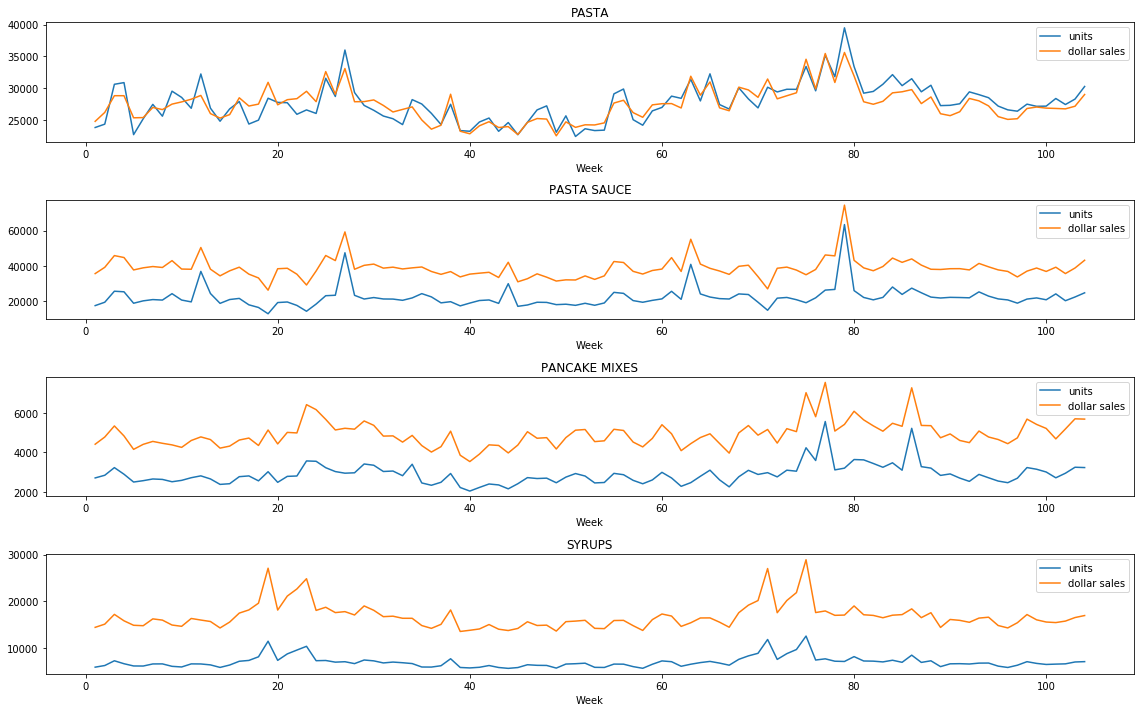

In [27]:
# plot both units sold and dollar sales for each category by week
fig, ax = plt.subplots(4, 1, figsize=(16, 10))
for i, name in enumerate(df.commodity.unique()):
    ax[i].plot(df[df.commodity == name].groupby('week').sum()['units'], label='units')
    ax[i].plot(df[df.commodity == name].groupby('week').sum()['dollar_sales'], label='dollar sales')
    ax[i].set_title(name.upper())
    ax[i].set_xlabel('Week')
    ax[i].legend()
    fig.tight_layout()


Dollar Sales and Units tend to follow the same trends in every category except Pasta, this seems to me like there's a lot of price flucuations in the pasta category, because a porudct sold at 1 dollar would have perfectly matched units and sales. This could be due to coupon use and sales, or varying brand popularity. 

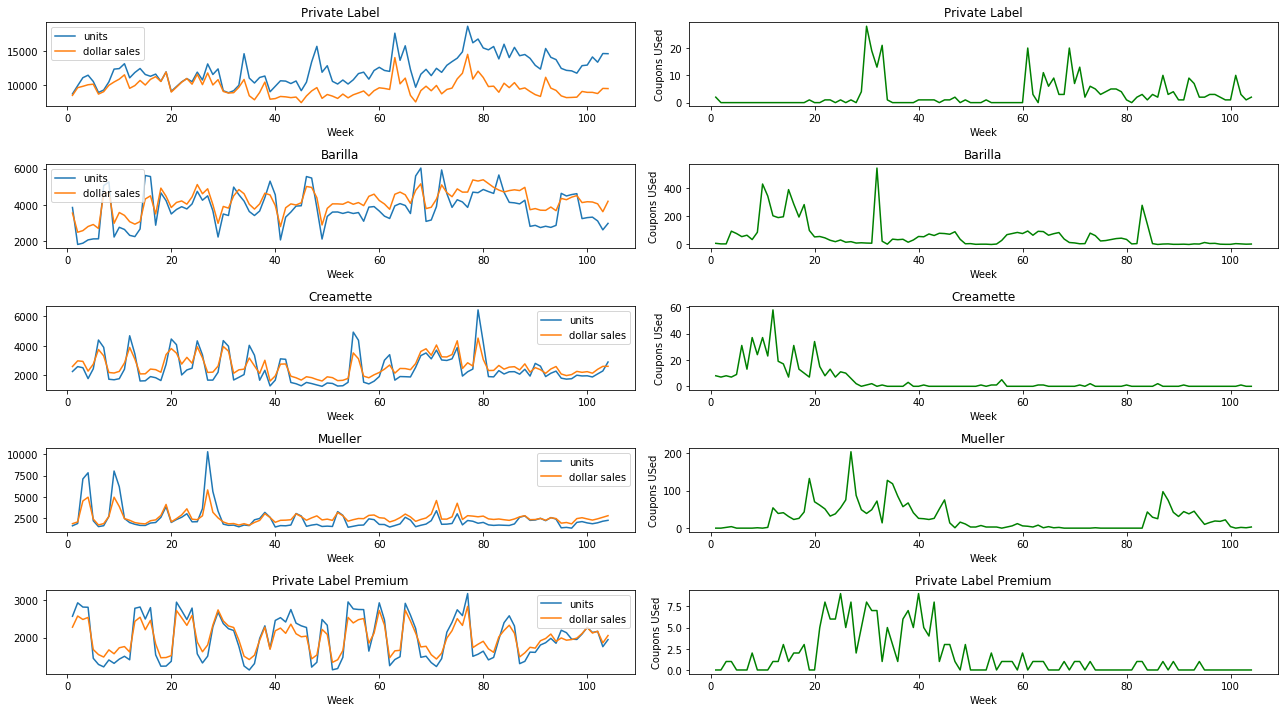

In [28]:
# going to look at trends within out Top 5 selling pasta brands

# find units sold by brand per week
week_brands = df[df.commodity=='pasta'].groupby(['brand', 'week']).sum()["units"]
# find coupon use by brand per week
coups = (df[df.commodity=='pasta'].groupby(['brand', 'week']).sum()['coupon'])

fig, ax = plt.subplots(5, 2, figsize=(18,10))
for i, brand in enumerate(top_brands[top_brands.commodity == 'pasta'].brand):
    ax[i,0].plot(week_brands[brand], label="units")
    ax[i,0].plot(df[df.commodity=='pasta'].groupby(['brand', 'week']).sum()["dollar_sales"][brand], label="dollar sales")
    ax[i,0].set_title(brand)
    ax[i,0].set_xlabel('Week')
    ax[i,0].legend()
    
    ax[i,1].plot(coups[brand], c='green')
    ax[i,1].set_title(brand)
    ax[i,1].set_xlabel('Week')
    ax[i,1].set_ylabel('Coupons USed')
    
    fig.tight_layout()

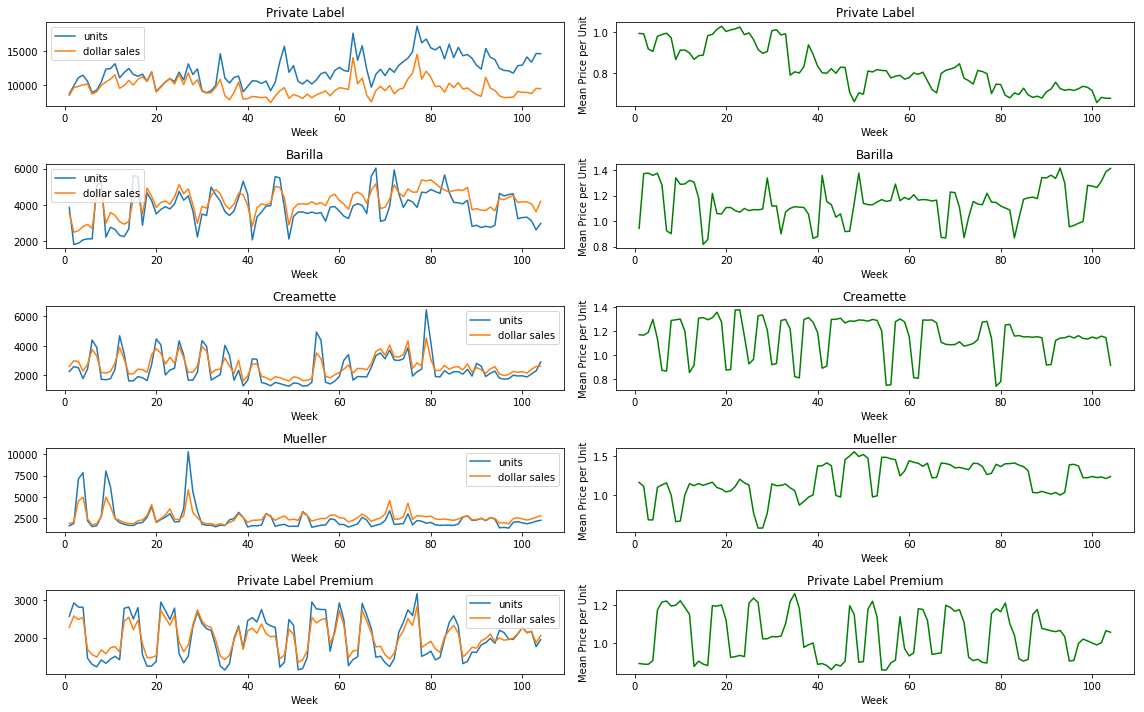

In [29]:
# do the same but for average price per unit of each brand by week
fig, ax = plt.subplots(5, 2, figsize=(16,10))
for i, brand in enumerate(top_brands[top_brands.commodity == 'pasta'].brand):
    ax[i,0].plot(week_brands[brand], label="units")
    ax[i,0].plot(df[df.commodity=='pasta'].groupby(['brand', 'week']).sum()["dollar_sales"][brand], label="dollar sales")
    ax[i,0].set_title(brand)
    ax[i,0].set_xlabel('Week')
    ax[i,0].legend()
    
    ax[i,1].plot(df[df.commodity=='pasta'].groupby(['brand', 'week']).mean()['ppu'][brand], c='green')
    ax[i,1].set_title(brand)
    ax[i,1].set_xlabel('Week')
    ax[i,1].set_ylabel('Mean Price per Unit')
    
    fig.tight_layout()

When comparing the graphs for Mean Price per Unit and sales (in both units and dollars), the inverse relationship between sales and price is apparent, this is an expected relationship, and there appear to be large swings in prices that oocur frequently. This could definitely explain the relationship between pasta units sold and pasts dollar sales. 

There doesn't seem to be a clear relationship between coupon use and sales however, this would lead me to believe that the flucuating price of pasta has more to do with promotions than coupons. This is under the assumption that a coupon is brought in by the customer while a promotion is an in store sale. 

Going back to a more general category overview I want to plot the sales against an average trend for sales.

In [30]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series, marker='.', label='Sales')
    ax.set_title("Sales For {}".format(name))
    
def fit_moving_average_trend(series, window=6):
    return series.rolling(window=window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=6):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend, marker='.', label='Average Trend')
    ax.legend()

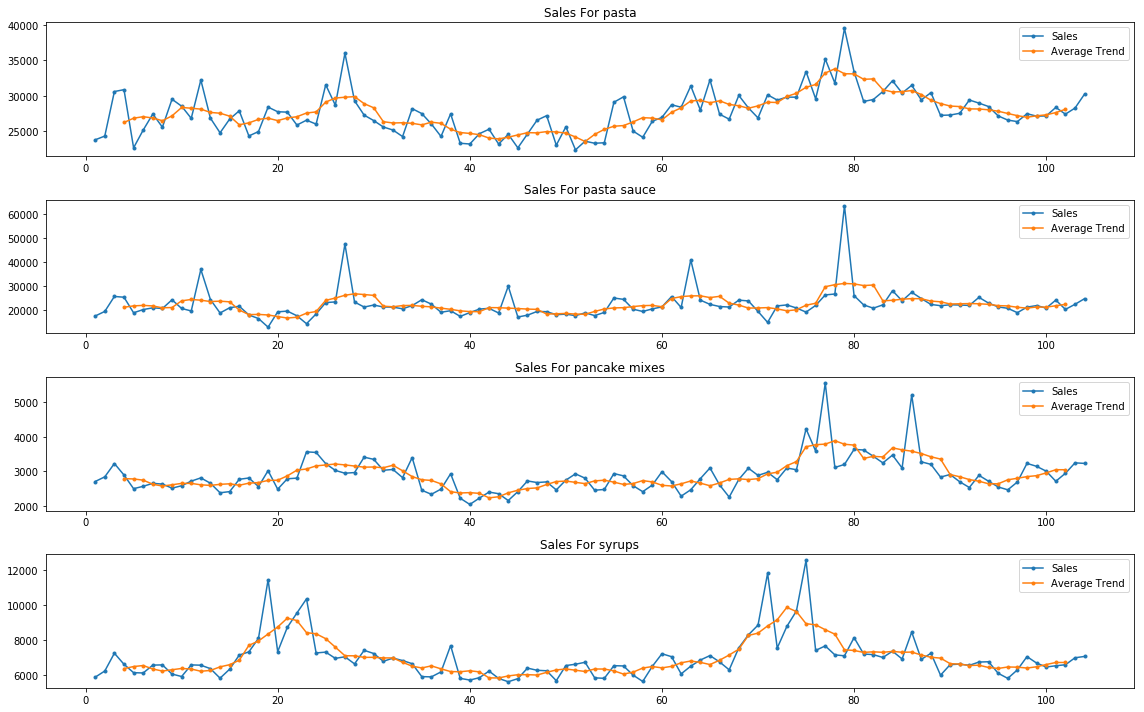

In [31]:
fig, ax = plt.subplots(4, figsize=(16,10))

for i, name in enumerate(df.commodity.unique()):
    plot_moving_average_trend(ax[i], name, df[df.commodity == name].groupby('week').sum()['units'])
    fig.tight_layout()

Overall, each category appears to have relatively steady sales, with both pasta and pancake mixes showing a small trend for growth. Interestingly Syrups seem to have a seasonality around the end of spring or beginning of summer, that doesnt correspond with pancake mix sales. Pasta Sauce sales spikes are in line with Pasta sales spikes but aren't overall increasing like pasta is.

#### Final Thoughts

I wasn't given any time guidelines for how long I should've spent on this case study so I did my best to answer all points without spending all my time on it. There are clearly areas that if I were to spend more time on I coudl delve further into, specifically the analysis of how brands and customers drive sales. I've presented everything in a jupyter notebook as this seemed to be a case study that involved quite a bit of exploratory data analysis and I find an ipython notebook to be well suited to that task.